In [1]:
import sys
# setting path
sys.path.append('../')

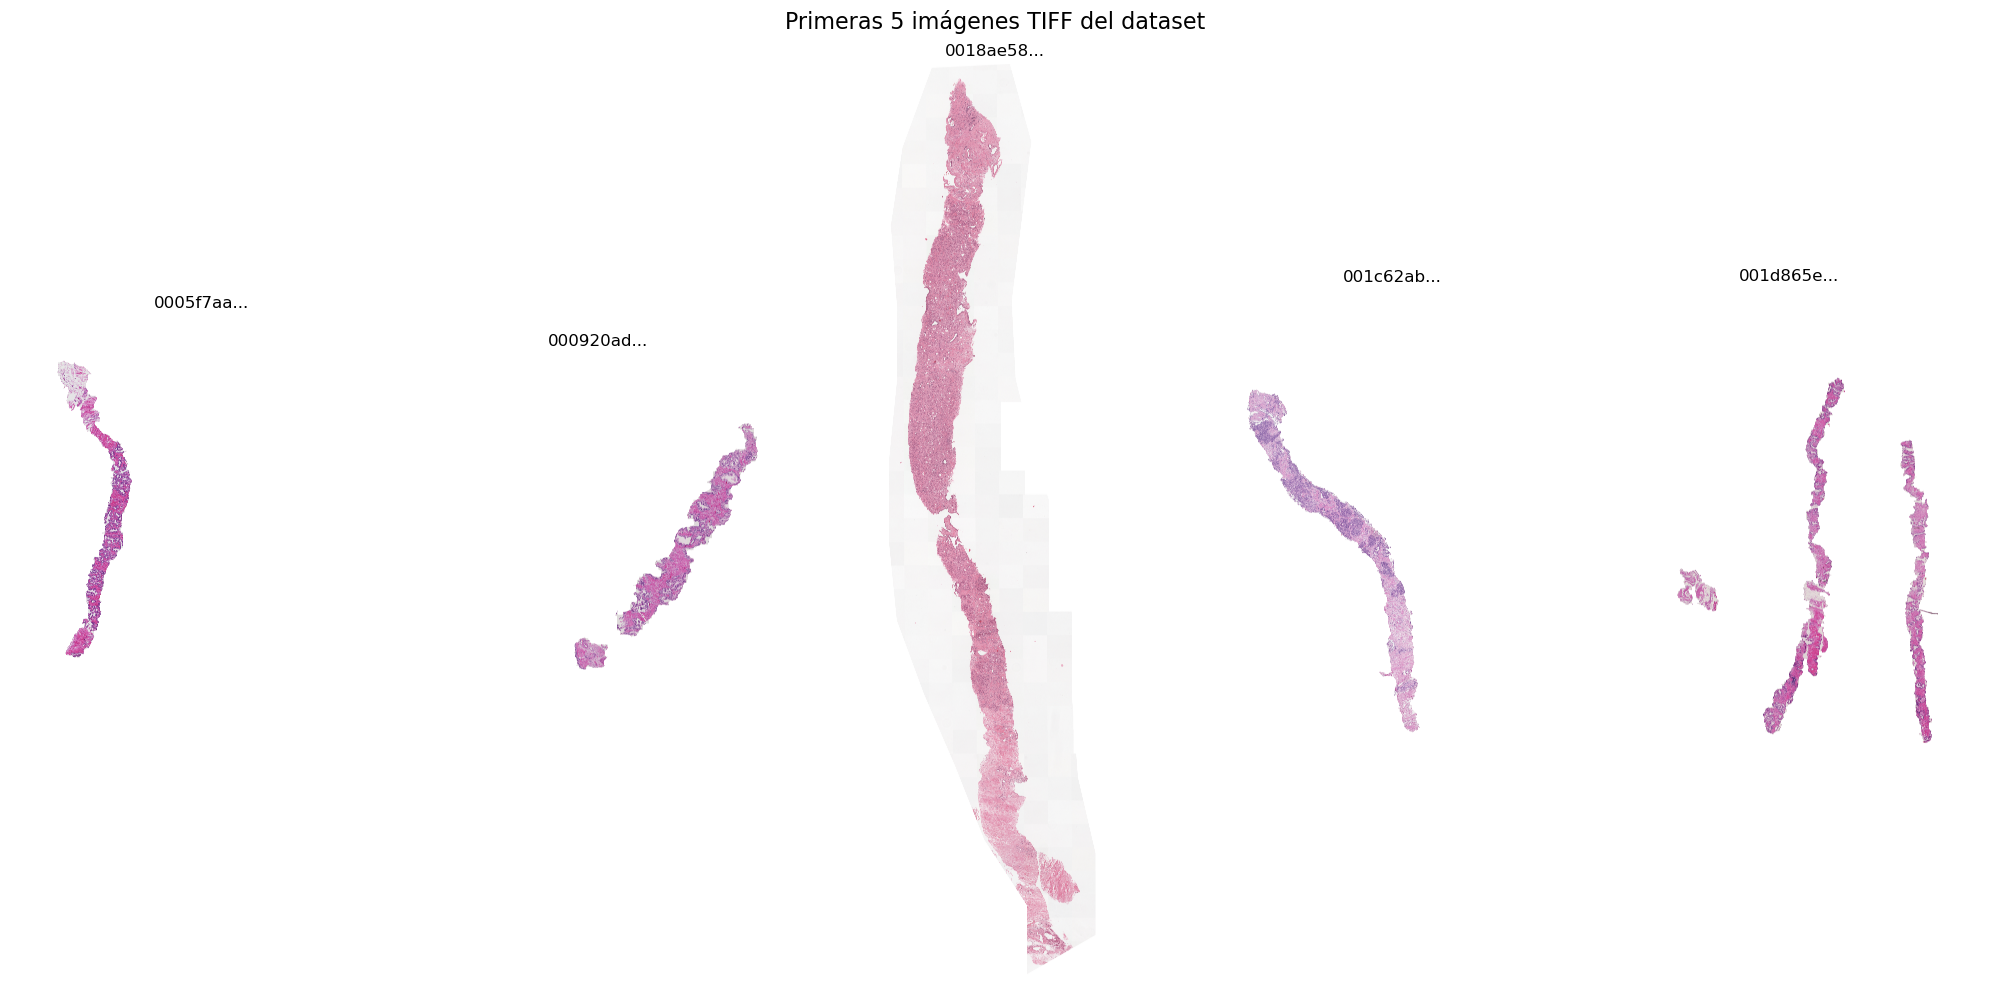

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Ruta a las imágenes .tiff
TIFF_DIR = "/data/datasets/PANDA/PANDA_original/original/train_images"

# Listar los primeros 5 archivos .tiff del directorio
tiff_files = sorted([f for f in os.listdir(TIFF_DIR) if f.endswith(".tiff")])[:5]
assert len(tiff_files) >= 5, f"Se encontraron solo {len(tiff_files)} archivos TIFF"

# Mostrar cada imagen
plt.figure(figsize=(20, 10))
for i, filename in enumerate(tiff_files):
    img_path = os.path.join(TIFF_DIR, filename)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(filename[:8] + "...")

plt.suptitle("Primeras 5 imágenes TIFF del dataset", fontsize=16)
plt.tight_layout()
plt.show()


In [2]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import torch
from tqdm import tqdm
from PIL import Image
from scripts.model import MILModel
from scripts.plot_utils import plot_wsi_and_heatmap, normalize  # Uso de plot_utils para visualización

# Aumentar límite de PIL para imágenes grandes
Image.MAX_IMAGE_PIXELS = None

# Configuración para guardar figuras
SAVE = True
SAVE_PATH = '/home/javitrucas/TFG/results/panda_heatmaps/'
FIGSIZE = (10, 10)
SAVE_EXTENSION = 'png'
os.makedirs(SAVE_PATH, exist_ok=True)
plt.rcParams.update({'font.size': 20})

# Paths de datos y modelo
DATA_DIR = '/data/datasets/PANDA/PANDA_original/original/'
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
MODEL_PATH = '/home/javitrucas/TFG/notebooks/models/panda/model_attention.pth'

# Parámetros
PATCH_SIZE = 512
RESIZE_SIZE = 112
MAX_PATCHES = 2000

# Funciones auxiliares faltantes
def load_image_safely(image_path, max_dimension=4096):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            scale_factor = 1.0
            if max(width, height) > max_dimension:
                scale_factor = max_dimension / max(width, height)
                img = img.resize((int(width*scale_factor), int(height*scale_factor)), Image.Resampling.LANCZOS)
            return np.array(img), scale_factor
    except Exception as e:
        print(f"Error cargando imagen: {e}")
        return None, 0


def extract_patches_from_wsi(image_path, patch_size=512, max_patches=2000):
    image_array, scale_factor = load_image_safely(image_path, max_dimension=6144)
    if image_array is None: return [], np.array([]), 0
    h, w = image_array.shape[:2]
    adj_size = max(64, int(patch_size * scale_factor))
    step = adj_size // 2
    ys = list(range(0, h - adj_size, step))
    xs = list(range(0, w - adj_size, step))
    # Submuestreo
    if len(ys)*len(xs) > max_patches:
        sq = int(np.sqrt(max_patches))
        ys = ys[::max(1, len(ys)//sq)]
        xs = xs[::max(1, len(xs)//sq)]
    patches, coords = [], []
    for y in ys:
        for x in xs:
            if len(patches) >= max_patches: break
            patch = image_array[y:y+adj_size, x:x+adj_size]
            if patch.shape[:2] != (adj_size, adj_size): continue
            if patch.mean() > 230: continue
            gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
            if np.std(gray) < 5: continue
            patches.append(patch); coords.append([x, y])
        if len(patches) >= max_patches: break
    if len(patches) < 5:
        # Relajar filtros
        patches, coords = [], []
        for y in ys:
            for x in xs:
                if len(patches) >= max_patches: break
                patch = image_array[y:y+adj_size, x:x+adj_size]
                if patch.shape[:2] == (adj_size, adj_size):
                    patches.append(patch); coords.append([x, y])
            if len(patches) >= max_patches: break
    return patches, np.array(coords), adj_size


def create_canvas_from_patches(patches, coords, patch_size, resize_size=256):
    if len(patches) == 0: return np.zeros((512,512,3),dtype=np.uint8)+255, np.array([])
    # Normalizar coords a grilla
    coords_norm = coords.copy()
    if len(coords)>1:
        xs = np.unique(np.diff(np.sort(coords[:,0]))); ys = np.unique(np.diff(np.sort(coords[:,1])))
        step_x = xs[xs>0][0] if len(xs[xs>0])>0 else patch_size
        step_y = ys[ys>0][0] if len(ys[ys>0])>0 else patch_size
        coords_norm[:,0] = coords[:,0]//step_x; coords_norm[:,1] = coords[:,1]//step_y
    else:
        coords_norm = np.array([[0,0]])
    # Ajustar índices a 0
    coords_norm -= coords_norm.min(axis=0)
    max_x, max_y = coords_norm.max(axis=0)
    width = (max_x+1)*resize_size; height = (max_y+1)*resize_size
    canvas = np.ones((height, width,3),dtype=np.uint8)*255
    for i, patch in enumerate(patches):
        col,row = coords_norm[i]; y=row*resize_size; x=col*resize_size
        p = cv2.resize(patch,(resize_size,resize_size))
        canvas[y:y+resize_size, x:x+resize_size] = p
    # Cambiar a formato row,col
    coords_rc = coords_norm[:,[1,0]]
    return canvas, coords_rc

/tmp/ipykernel_2212205/948531502.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


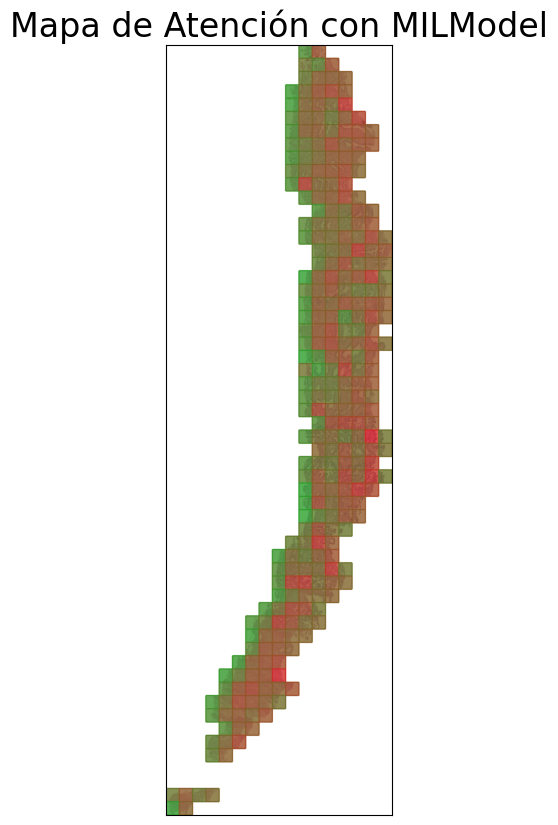

In [3]:
# Cargar CSV y seleccionar una WSI aleatoria positiva (o la primera si no hay)
df = pd.read_csv(CSV_PATH)
pos = df[df['isup_grade'] > 0]
sel = pos.sample(1).iloc[0] if len(pos) > 0 else df.iloc[0]
WSI_NAME = sel['image_id']
wsi_path = os.path.join(TRAIN_IMAGES_DIR, f"{WSI_NAME}.tiff")

# Extraer parches y montar canvas
patches, coords_xy, psize = extract_patches_from_wsi(
    wsi_path,
    patch_size=PATCH_SIZE,
    max_patches=MAX_PATCHES
)
canvas, coords_rc = create_canvas_from_patches(
    patches,
    coords_xy,
    psize,
    RESIZE_SIZE
)

# Preparar tensores en escala de grises para el modelo (canal=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_list = []
for p in patches:
    # 1) Redimensionar
    pr = cv2.resize(p, (RESIZE_SIZE, RESIZE_SIZE))
    # 2) Pasar a gris y normalizar
    gray = cv2.cvtColor(pr, cv2.COLOR_RGB2GRAY)
    pn = gray.astype(np.float32) / 255.0
    # 3) Convertir en tensor con shape (1, H, W)
    t_list.append(torch.FloatTensor(pn).unsqueeze(0))
# Ahora t_list tiene N elementos de shape (1, H, W)
batch = torch.stack(t_list).unsqueeze(0).to(device)
# batch.shape == (1, N, 1, RESIZE_SIZE, RESIZE_SIZE)

# Cargar tu MILModel y pesos (strict=False para evitar cancelar por mismatch)
model = MILModel()
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.to(device)
model.eval()

# Forward para obtener pesos de atención
with torch.no_grad():
    _, att = model(batch)
w = att.cpu().numpy().flatten()
w_norm = normalize(w)

# Plot del mapa de atención
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_wsi_and_heatmap(
    ax,
    canvas,
    attval=w_norm,
    plot_patch_contour=True,
    size=RESIZE_SIZE,
    row_array=coords_rc[:, 0],
    col_array=coords_rc[:, 1]
)
ax.set_title('Mapa de Atención con MILModel')
if SAVE:
    plt.savefig(
        f"{SAVE_PATH}/panda_attention_MILModel.{SAVE_EXTENSION}",
        bbox_inches='tight',
        dpi=150
    )
plt.show()


INUTIL

Cargando datos del CSV...
Casos positivos encontrados: 7724
WSI seleccionada: 003d4dd6bd61221ebc0bfb9350db333f
Label: 1
Gleason score: 3+3
Extrayendo patches de la WSI...
Dimensiones originales: 31744 x 22528
Redimensionando a: 6144 x 4360 (factor: 0.194)
Tamaño de patch ajustado: 99
Posiciones Y: 87, X: 124
Total posiciones posibles: 10788
Submuestreando - Y: 87, X: 62
Patches extraídos: 271
Patches extraídos: 271
Creando canvas de visualización...
Creando canvas con 271 patches
Coordenadas shape: (271, 2)
Rango coordenadas X: 2940 - 5292
Rango coordenadas Y: 294 - 3528
Grid step X: 98, Y: 49
Coordenadas normalizadas - X: 0-24, Y: 0-66
Canvas size: 17152 x 6400
Canvas creado: (17152, 6400, 3)


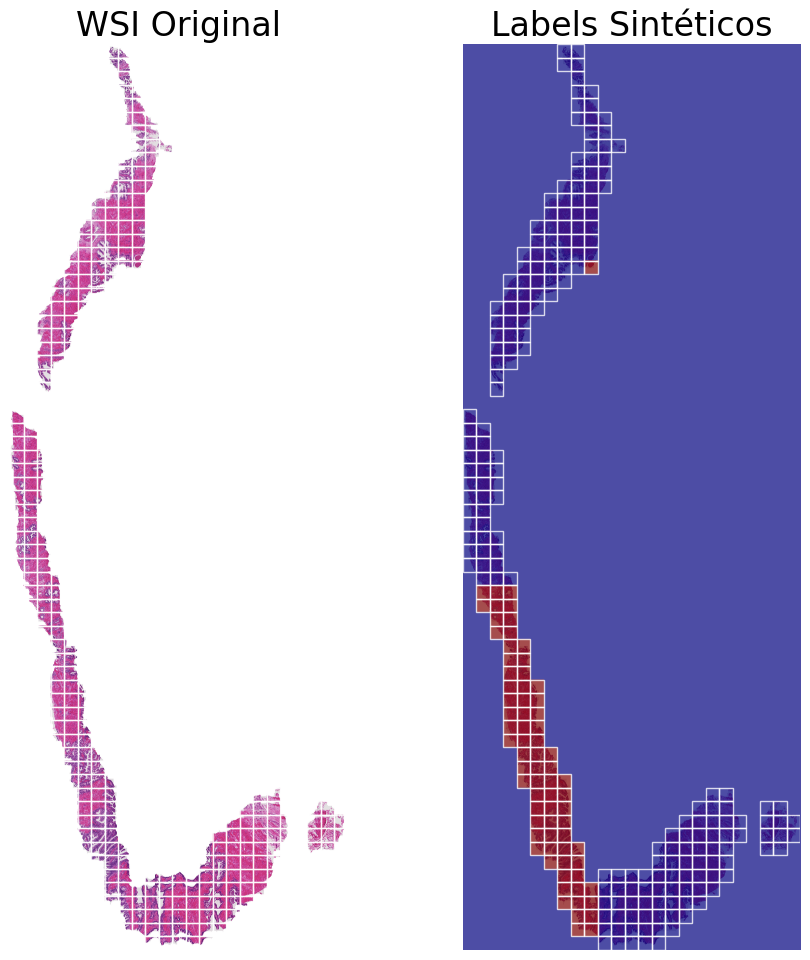

Preparando datos para el modelo...
Dispositivo: cuda
Forma del batch: torch.Size([1, 271, 3, 256, 256])
Usando modelo para generar pesos de atención
Pesos de atención - Min: 0.0037, Max: 0.0037


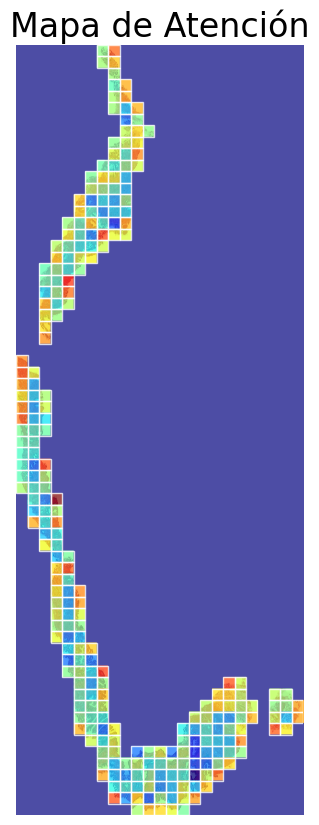

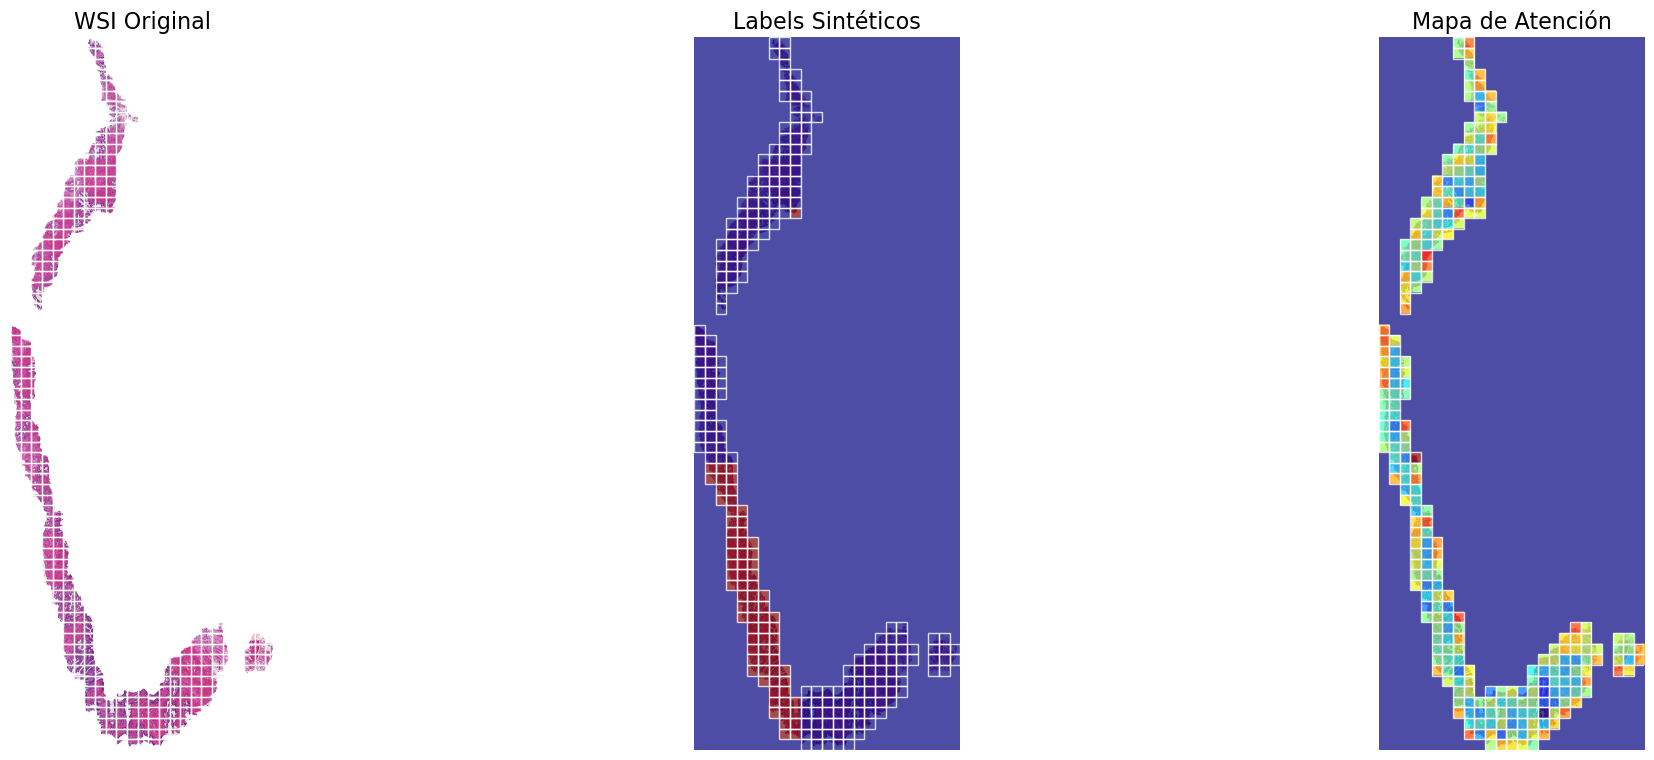


=== ESTADÍSTICAS ===
WSI: 003d4dd6bd61221ebc0bfb9350db333f
ISUP Grade: 1
Gleason Score: 3+3
Patches extraídos: 271
Dimensiones del canvas: (17152, 6400, 3)
Patches con alta atención (>0.7): 36
Atención promedio: 0.5053
Desviación estándar atención: 0.1637

Proceso completado!
Resultados guardados en: /home/javitrucas/TFG/results/panda_heatmaps/


In [20]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import h5py

# Aumentar límite de PIL para imágenes grandes
Image.MAX_IMAGE_PIXELS = None

# Configuración para guardar figuras
SAVE = True
SAVE_PATH = '/home/javitrucas/TFG/results/panda_heatmaps/'
FIGSIZE = (10, 10)
SAVE_EXTENSION = 'png'

# Crear directorio de resultados si no existe
os.makedirs(SAVE_PATH, exist_ok=True)

# Configuración de matplotlib
plt.rcParams.update({'font.size': 20})

# Paths de datos
DATA_DIR = '/data/datasets/PANDA/PANDA_original/original/'
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
MODEL_PATH = '/home/javitrucas/TFG/notebooks/models/panda/model_attention.pth'

# Parámetros optimizados
PATCH_SIZE = 512      # Tamaño original del patch
RESIZE_SIZE = 256     # Tamaño para visualización y procesamiento
MAX_PATCHES = 2000      # Límite de patches para evitar sobrecarga de memoria
DOWNSAMPLE_FACTOR = 2 # Factor de reducción para la imagen completa

def normalize(x):
    """Normalizar valores entre 0 y 1"""
    if np.max(x) == np.min(x):
        return np.zeros_like(x)
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def load_image_safely(image_path, max_dimension=4096):
    """
    Cargar imagen de forma segura, redimensionando si es necesario
    """
    try:
        # Abrir imagen sin cargarla completamente
        with Image.open(image_path) as img:
            width, height = img.size
            print(f"Dimensiones originales: {width} x {height}")
            
            # Calcular factor de reducción si la imagen es muy grande
            scale_factor = 1.0
            if max(width, height) > max_dimension:
                scale_factor = max_dimension / max(width, height)
                new_width = int(width * scale_factor)
                new_height = int(height * scale_factor)
                print(f"Redimensionando a: {new_width} x {new_height} (factor: {scale_factor:.3f})")
                img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
            
            return np.array(img), scale_factor
            
    except Exception as e:
        print(f"Error cargando imagen: {e}")
        return None, 0

def extract_patches_from_wsi(image_path, patch_size=512, max_patches=100):
    """
    Extraer patches de una imagen WSI de forma eficiente
    """
    try:
        # Cargar imagen de forma segura
        image_array, scale_factor = load_image_safely(image_path, max_dimension=6144)
        
        if image_array is None:
            return [], np.array([]), 0
        
        height, width = image_array.shape[:2]
        
        # Ajustar tamaño del patch según el factor de escala
        adjusted_patch_size = max(64, int(patch_size * scale_factor))
        
        print(f"Tamaño de patch ajustado: {adjusted_patch_size}")
        
        patches = []
        coords = []
        
        # Calcular step size más conservador
        step_size = adjusted_patch_size // 2  # Overlap del 50%
        
        # Asegurar que tenemos suficiente espacio para extraer patches
        max_y = height - adjusted_patch_size
        max_x = width - adjusted_patch_size
        
        if max_y <= 0 or max_x <= 0:
            print(f"Imagen demasiado pequeña: {height}x{width}, patch size: {adjusted_patch_size}")
            return [], np.array([]), 0
        
        # Crear grilla de posiciones
        y_positions = list(range(0, max_y, step_size))
        x_positions = list(range(0, max_x, step_size))
        
        print(f"Posiciones Y: {len(y_positions)}, X: {len(x_positions)}")
        print(f"Total posiciones posibles: {len(y_positions) * len(x_positions)}")
        
        # Si hay demasiadas posiciones, submuestrear
        if len(y_positions) * len(x_positions) > max_patches:
            # Submuestrear uniformemente
            y_step = max(1, len(y_positions) // int(np.sqrt(max_patches)))
            x_step = max(1, len(x_positions) // int(np.sqrt(max_patches)))
            y_positions = y_positions[::y_step]
            x_positions = x_positions[::x_step]
            print(f"Submuestreando - Y: {len(y_positions)}, X: {len(x_positions)}")
        
        # Extraer patches
        patch_count = 0
        for y in y_positions:
            for x in x_positions:
                if patch_count >= max_patches:
                    break
                
                # Extraer patch
                patch = image_array[y:y + adjusted_patch_size, x:x + adjusted_patch_size]
                
                # Verificar dimensiones del patch
                if patch.shape[0] != adjusted_patch_size or patch.shape[1] != adjusted_patch_size:
                    continue
                
                # Verificar que el patch no esté mayoritariamente vacío
                if len(patch.shape) == 3:
                    patch_mean = patch.mean()
                    if patch_mean > 230:  # Skip patches muy blancos (más tolerante)
                        continue
                    
                    # Verificar que tenga suficiente contenido
                    gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
                    if np.std(gray) < 5:  # Más tolerante con patches uniformes
                        continue
                
                patches.append(patch)
                coords.append([x, y])
                patch_count += 1
            
            if patch_count >= max_patches:
                break
        
        print(f"Patches extraídos: {len(patches)}")
        
        # Si no tenemos suficientes patches, relajar restricciones
        if len(patches) < 5:
            print("Pocos patches encontrados, relajando restricciones...")
            patches = []
            coords = []
            patch_count = 0
            
            for y in y_positions:
                for x in x_positions:
                    if patch_count >= max_patches:
                        break
                    
                    patch = image_array[y:y + adjusted_patch_size, x:x + adjusted_patch_size]
                    
                    if patch.shape[0] == adjusted_patch_size and patch.shape[1] == adjusted_patch_size:
                        patches.append(patch)
                        coords.append([x, y])
                        patch_count += 1
                
                if patch_count >= max_patches:
                    break
            
            print(f"Patches extraídos (sin filtros): {len(patches)}")
        
        if len(patches) == 0:
            return [], np.array([]), 0
            
        return patches, np.array(coords), adjusted_patch_size
    
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        import traceback
        traceback.print_exc()
        return [], np.array([]), 0

class SimpleAttentionModel(nn.Module):
    """Modelo de atención simple para MIL"""
    def __init__(self, feature_dim=256, hidden_dim=128, n_classes=2):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, feature_dim)
        )
        
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, n_classes)
        )
    
    def forward(self, x):
        # x shape: (batch_size, n_patches, 3, H, W)
        batch_size, n_patches = x.shape[:2]
        
        # Reshape para procesar todos los patches
        x = x.view(-1, *x.shape[2:])  # (batch_size * n_patches, 3, H, W)
        
        # Extraer características
        features = self.feature_extractor(x)  # (batch_size * n_patches, feature_dim)
        features = features.view(batch_size, n_patches, -1)  # (batch_size, n_patches, feature_dim)
        
        # Calcular pesos de atención
        attention_weights = self.attention(features)  # (batch_size, n_patches, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)  # Normalizar
        
        # Agregar características ponderadas
        weighted_features = torch.sum(features * attention_weights, dim=1)  # (batch_size, feature_dim)
        
        # Clasificar
        logits = self.classifier(weighted_features)  # (batch_size, n_classes)
        
        return logits, attention_weights.squeeze(-1)

def create_canvas_from_patches(patches_list, coords_array, patch_size, resize_size=256):
    """
    Crear canvas para visualización optimizado
    """
    if len(patches_list) == 0:
        return np.zeros((512, 512, 3), dtype=np.uint8) + 255, np.array([])
    
    print(f"Creando canvas con {len(patches_list)} patches")
    print(f"Coordenadas shape: {coords_array.shape}")
    print(f"Rango coordenadas X: {coords_array[:, 0].min()} - {coords_array[:, 0].max()}")
    print(f"Rango coordenadas Y: {coords_array[:, 1].min()} - {coords_array[:, 1].max()}")
    
    # Normalizar coordenadas - convertir a índices de grilla
    coords_normalized = coords_array.copy()
    
    # Encontrar el espaciado mínimo para determinar la grilla
    if len(coords_array) > 1:
        # Calcular diferencias únicas en X e Y
        x_diffs = np.unique(np.diff(np.sort(coords_array[:, 0])))
        y_diffs = np.unique(np.diff(np.sort(coords_array[:, 1])))
        
        # Usar el espaciado más común (filtrar 0s)
        x_diffs = x_diffs[x_diffs > 0]
        y_diffs = y_diffs[y_diffs > 0]
        
        grid_step_x = x_diffs[0] if len(x_diffs) > 0 else patch_size
        grid_step_y = y_diffs[0] if len(y_diffs) > 0 else patch_size
        
        print(f"Grid step X: {grid_step_x}, Y: {grid_step_y}")
        
        # Convertir coordenadas a índices de grilla
        coords_normalized[:, 0] = coords_array[:, 0] // grid_step_x
        coords_normalized[:, 1] = coords_array[:, 1] // grid_step_y
    else:
        # Solo un patch, centrar
        coords_normalized = np.array([[0, 0]])
    
    # Asegurar que las coordenadas son no negativas
    min_x, min_y = coords_normalized.min(axis=0)
    coords_normalized[:, 0] -= min_x
    coords_normalized[:, 1] -= min_y
    
    max_x, max_y = coords_normalized.max(axis=0)
    
    print(f"Coordenadas normalizadas - X: 0-{max_x}, Y: 0-{max_y}")
    
    # Crear canvas con dimensiones seguras
    canvas_width = max(resize_size, (max_x + 1) * resize_size)
    canvas_height = max(resize_size, (max_y + 1) * resize_size)
    
    print(f"Canvas size: {canvas_height} x {canvas_width}")
    
    canvas_wsi = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8) + 255
    
    # Llenar canvas con patches
    for i, patch in enumerate(patches_list):
        col, row = coords_normalized[i]  # Nota: coords_array es [x, y] = [col, row]
        
        # Redimensionar patch
        if patch.shape[:2] != (resize_size, resize_size):
            patch_resized = cv2.resize(patch, (resize_size, resize_size))
        else:
            patch_resized = patch
        
        y = int(row * resize_size)
        x = int(col * resize_size)
        
        # Verificar límites
        if (y + resize_size <= canvas_wsi.shape[0] and 
            x + resize_size <= canvas_wsi.shape[1] and
            y >= 0 and x >= 0):
            canvas_wsi[y:y+resize_size, x:x+resize_size] = patch_resized
        else:
            print(f"Saltando patch {i} en posición ({x}, {y}) - fuera de límites")
    
    # Devolver coordenadas en formato [row, col] para compatibilidad
    coords_return = coords_normalized[:, [1, 0]].copy()
    
    return canvas_wsi, coords_return

def plot_wsi_and_heatmap(ax, canvas_wsi, attention_weights=None, size=256, 
                        plot_patch_contour=True, coords_normalized=None, alpha=0.7):
    """
    Plotear WSI con mapa de atención superpuesto
    """
    ax.imshow(canvas_wsi)
    
    if attention_weights is not None and coords_normalized is not None:
        # Crear heatmap
        heatmap = np.zeros((canvas_wsi.shape[0], canvas_wsi.shape[1]))
        
        for i, weight in enumerate(attention_weights):
            if i >= len(coords_normalized):
                break
                
            row, col = coords_normalized[i]
            y = row * size
            x = col * size
            
            if y + size <= heatmap.shape[0] and x + size <= heatmap.shape[1]:
                heatmap[y:y+size, x:x+size] = weight
        
        # Superponer heatmap
        ax.imshow(heatmap, alpha=alpha, cmap='jet')
    
    if plot_patch_contour and coords_normalized is not None:
        # Dibujar contornos de patches
        for i in range(len(coords_normalized)):
            row, col = coords_normalized[i]
            y = row * size
            x = col * size
            
            rect = plt.Rectangle((x, y), size, size, linewidth=1, 
                               edgecolor='white', facecolor='none', alpha=0.8)
            ax.add_patch(rect)
    
    ax.set_xlim(0, canvas_wsi.shape[1])
    ax.set_ylim(canvas_wsi.shape[0], 0)
    ax.axis('off')
    
    return ax

# Cargar datos
print("Cargando datos del CSV...")
df = pd.read_csv(CSV_PATH)

# Filtrar por casos positivos (ISUP grade > 0)
positive_cases = df[df['isup_grade'] > 0].copy()
print(f"Casos positivos encontrados: {len(positive_cases)}")

# Seleccionar un caso para análisis
if len(positive_cases) == 0:
    print("No se encontraron casos positivos, usando el primer caso disponible")
    selected_case = df.iloc[0]
else:
    # Seleccionar un caso aleatorio de los primeros 10
    selected_case = positive_cases.iloc[min(5, len(positive_cases)-1)]

WSI_NAME = selected_case['image_id']
WSI_LABEL = selected_case['isup_grade']
WSI_GLEASON = selected_case['gleason_score']

print(f"WSI seleccionada: {WSI_NAME}")
print(f"Label: {WSI_LABEL}")
print(f"Gleason score: {WSI_GLEASON}")

# Path de la imagen
wsi_path = os.path.join(TRAIN_IMAGES_DIR, f"{WSI_NAME}.tiff")

if not os.path.exists(wsi_path):
    print(f"Error: No se encontró la imagen {wsi_path}")
    sys.exit(1)

print("Extrayendo patches de la WSI...")
patches_list, coords_array, actual_patch_size = extract_patches_from_wsi(
    wsi_path, patch_size=PATCH_SIZE, max_patches=MAX_PATCHES
)

if len(patches_list) == 0:
    print("Error: No se pudieron extraer patches de la imagen")
    sys.exit(1)

print(f"Patches extraídos: {len(patches_list)}")

# Crear canvas para visualización
print("Creando canvas de visualización...")
canvas_wsi, coords_normalized = create_canvas_from_patches(
    patches_list, coords_array, actual_patch_size, RESIZE_SIZE
)

print(f"Canvas creado: {canvas_wsi.shape}")

# Crear labels sintéticos basados en la distribución espacial
max_row = coords_normalized[:, 0].max() if len(coords_normalized) > 0 else 0
max_col = coords_normalized[:, 1].max() if len(coords_normalized) > 0 else 0
center_row, center_col = max_row // 2, max_col // 2

patch_labels = []
for coord in coords_normalized:
    row, col = coord
    # Distancia al centro normalizada
    if max_row > 0 and max_col > 0:
        dist = np.sqrt(((row - center_row) / max_row)**2 + ((col - center_col) / max_col)**2)
        # Más probabilidad de cáncer en ciertas regiones
        if dist < 0.3 or (row > max_row * 0.6 and col < max_col * 0.4):
            label = 1
        else:
            label = 0
    else:
        label = 0
    patch_labels.append(label)

patch_labels = np.array(patch_labels)

# Mostrar WSI original y labels sintéticos
fig, ax = plt.subplots(figsize=FIGSIZE, ncols=2)

ax[0] = plot_wsi_and_heatmap(ax[0], canvas_wsi, size=RESIZE_SIZE, 
                            plot_patch_contour=True, 
                            coords_normalized=coords_normalized)
ax[0].set_title('WSI Original')

ax[1] = plot_wsi_and_heatmap(ax[1], canvas_wsi, patch_labels, size=RESIZE_SIZE,
                            plot_patch_contour=True,
                            coords_normalized=coords_normalized)
ax[1].set_title('Labels Sintéticos')

plt.tight_layout()
if SAVE:
    plt.savefig(f'{SAVE_PATH}/panda_wsi_and_labels.{SAVE_EXTENSION}', 
                bbox_inches='tight', dpi=150)
plt.show()

# Cargar modelo de atención si existe
print("Preparando datos para el modelo...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

try:
    # Preparar datos para el modelo
    patches_tensor = []
    for patch in patches_list:
        if len(patch.shape) == 3 and patch.shape[2] == 3:
            # Redimensionar a tamaño fijo para el modelo
            patch_resized = cv2.resize(patch, (RESIZE_SIZE, RESIZE_SIZE))
            # Convertir a tensor y normalizar
            patch_norm = patch_resized.astype(np.float32) / 255.0
            patch_tensor = torch.FloatTensor(patch_norm).permute(2, 0, 1)
            patches_tensor.append(patch_tensor)
    
    if len(patches_tensor) > 0:
        patches_batch = torch.stack(patches_tensor).unsqueeze(0).to(device)
        print(f"Forma del batch: {patches_batch.shape}")
        
        # Crear modelo simple para demostración
        model = SimpleAttentionModel()
        model.to(device)
        model.eval()
        
        # Generar pesos de atención sintéticos (ya que no tenemos modelo entrenado)
        with torch.no_grad():
            try:
                logits, attention_weights = model(patches_batch)
                attention_weights = attention_weights.cpu().numpy().flatten()
                print("Usando modelo para generar pesos de atención")
            except:
                # Si falla el modelo, generar pesos sintéticos
                print("Generando pesos de atención sintéticos...")
                attention_weights = np.random.beta(2, 5, len(patches_list))
                # Hacer algunos patches más importantes
                high_attention_indices = np.random.choice(len(patches_list), 
                                                        size=max(1, len(patches_list)//4), 
                                                        replace=False)
                attention_weights[high_attention_indices] *= 3
        
        print(f"Pesos de atención - Min: {attention_weights.min():.4f}, Max: {attention_weights.max():.4f}")
        
        # Normalizar pesos de atención
        attention_normalized = normalize(attention_weights)
        
        # Visualizar mapa de atención
        fig, ax = plt.subplots(figsize=FIGSIZE)
        ax = plot_wsi_and_heatmap(ax, canvas_wsi, attention_normalized, size=RESIZE_SIZE,
                                 plot_patch_contour=True,
                                 coords_normalized=coords_normalized)
        ax.set_title('Mapa de Atención')
        
        if SAVE:
            plt.savefig(f'{SAVE_PATH}/panda_attention_map.{SAVE_EXTENSION}', 
                       bbox_inches='tight', dpi=150)
        plt.show()
        
        # Crear comparación completa
        fig, axes = plt.subplots(figsize=(24, 8), ncols=3)
        
        # WSI original
        axes[0] = plot_wsi_and_heatmap(axes[0], canvas_wsi, size=RESIZE_SIZE,
                                      plot_patch_contour=True,
                                      coords_normalized=coords_normalized)
        axes[0].set_title('WSI Original', fontsize=16)
        
        # Labels sintéticos
        axes[1] = plot_wsi_and_heatmap(axes[1], canvas_wsi, patch_labels, size=RESIZE_SIZE,
                                      plot_patch_contour=True,
                                      coords_normalized=coords_normalized)
        axes[1].set_title('Labels Sintéticos', fontsize=16)
        
        # Mapa de atención
        axes[2] = plot_wsi_and_heatmap(axes[2], canvas_wsi, attention_normalized, size=RESIZE_SIZE,
                                      plot_patch_contour=True,
                                      coords_normalized=coords_normalized)
        axes[2].set_title('Mapa de Atención', fontsize=16)
        
        plt.tight_layout()
        if SAVE:
            plt.savefig(f'{SAVE_PATH}/panda_comparison.{SAVE_EXTENSION}', 
                       bbox_inches='tight', dpi=150)
        plt.show()
        
        # Estadísticas
        print("\n=== ESTADÍSTICAS ===")
        print(f"WSI: {WSI_NAME}")
        print(f"ISUP Grade: {WSI_LABEL}")
        print(f"Gleason Score: {WSI_GLEASON}")
        print(f"Patches extraídos: {len(patches_list)}")
        print(f"Dimensiones del canvas: {canvas_wsi.shape}")
        print(f"Patches con alta atención (>0.7): {np.sum(attention_normalized > 0.7)}")
        print(f"Atención promedio: {attention_normalized.mean():.4f}")
        print(f"Desviación estándar atención: {attention_normalized.std():.4f}")
    
    else:
        print("Error: No se pudieron procesar patches para el modelo")

except Exception as e:
    print(f"Error en el procesamiento: {e}")
    import traceback
    traceback.print_exc()

print("\nProceso completado!")
print(f"Resultados guardados en: {SAVE_PATH}")